# A Tale on GLM (Generalized Linear Model)

So the story begins when I am trying to compare GLM output from R and Python and I found out that the result are similar but not exactly the same. The answer is obvious, it is due to their optimization algorithm even when the two of them use Iterated Reweighted Least Square (IRLS). This bug me quite a bit since when I try to use other optimization technique, e.g. Nelder-Mead (NM), Broyden-Fletcher-Goldfarb-Shanno (BFGS),the result differ quite significant.  

On the other hand, I also have been tweaking a little bit on deep learning using PyTorch libraries and I have no confidence on the code I wrote since there is no numerical result to compare. So, here we are.

This notebook won't discuss anything on the optimization method and why it works and also won't discuss the basic of GLM since I believe there are a lot of resources which is very clear to explain (my recommendation is [AItools4Actuaries](https://aitools4actuaries.com/Ch3/Ch3A%20GLM.html)).  

This notebook is a personal note to memorize how to estimate the predictor in GLM (since one of my client asked me and I am not satisfy with my answer) and to familiarize on PyTorch framework.

# Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import glm

# Generate Data

For simplicity, we assume we have 3 predictor (`variable_1`, `variable_2` and `variable_3`) and we are going to assume the `claim_count` is Poisson ($\lambda$) distributed with $\lambda$ as follow 
$$
\lambda = 1.2 + 0.4 \mathbb{I}_{x_1 = a} - 0.3\mathbb{I}_{x_1 = a} + 0.8 \mathbb{I}_{x_1 = a}  - 0.2 x_2 + 1.2 \cos{(x_3)} + \log(\text{offset})
$$
where $\mathbb{I}_{x_1 = a}$ is an indicator function if `variable_1` is `a`

In [2]:
np.random.seed(108)
n_obs = 100_000

model_df = pd.DataFrame({
    'variable_1' : np.random.choice(a=['a', 'b', 'c'], size=n_obs),
    'variable_2' : np.random.uniform(low=0, high=20, size=n_obs),
    'variable_3' : np.random.normal(loc = 0, scale = 1, size = n_obs),
    'exposure' : np.round(np.random.uniform(low=0.2, high=1, size=n_obs),4),
    })
model_df['lambda'] = 1.2 + model_df['variable_1'].map({'a': 0.4, 'b': -0.3, 'c': 0.8}) - 0.2*model_df['variable_2'] + 1.2*np.cos(model_df['variable_3']) + np.log(model_df['exposure'])
model_df['lambda'] = model_df['lambda'].clip(0)
model_df['claim_count'] = np.random.poisson(lam = model_df['lambda'])
model_df

,variable_1,variable_2,variable_3,exposure,lambda,claim_count
0,b,7.563060,-0.302359,0.3453,0.000000,0
1,c,5.419909,-0.041613,0.7115,1.774599,0
2,c,4.864539,-0.013409,0.9464,2.171894,1
3,c,12.394991,-1.153324,0.3808,0.000000,0
4,a,1.471028,-0.435920,0.7594,2.118346,0
...,...,...,...,...,...,...
99995,c,14.483830,-1.442644,0.6825,0.000000,0
99996,c,17.158324,-1.057541,0.3563,0.000000,0
99997,b,10.751592,-0.409207,0.2165,0.000000,0
99998,a,15.931183,-0.500684,0.7192,0.000000,0


In [3]:
model_df.describe()

,variable_2,variable_3,exposure,lambda,claim_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,10.004643,-0.005549,0.599431,0.414768,0.412240
std,5.789280,1.001687,0.230828,0.662364,0.919993
min,0.000395,-4.432830,0.200000,0.000000,0.000000
25%,4.992231,-0.679859,0.399100,0.000000,0.000000
50%,10.010667,-0.003232,0.599000,0.000000,0.000000
75%,15.018346,0.667645,0.798800,0.696589,0.000000
max,19.999914,4.259687,1.000000,3.162738,11.000000


In [4]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   variable_1   100000 non-null  object 
 1   variable_2   100000 non-null  float64
 2   variable_3   100000 non-null  float64
 3   exposure     100000 non-null  float64
 4   lambda       100000 non-null  float64
 5   claim_count  100000 non-null  int32  
dtypes: float64(4), int32(1), object(1)
memory usage: 4.2+ MB


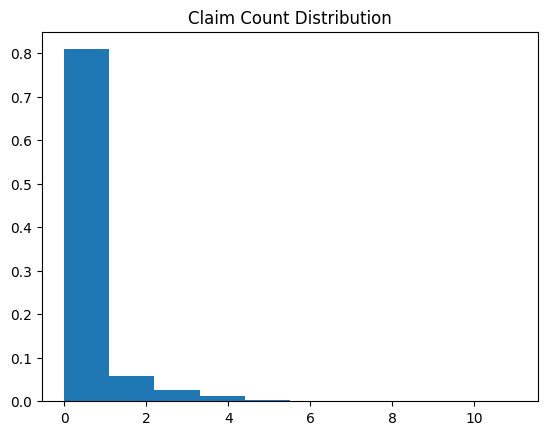

In [5]:
plt.hist(model_df['claim_count'], density= True)
plt.title('Claim Count Distribution')
plt.show()

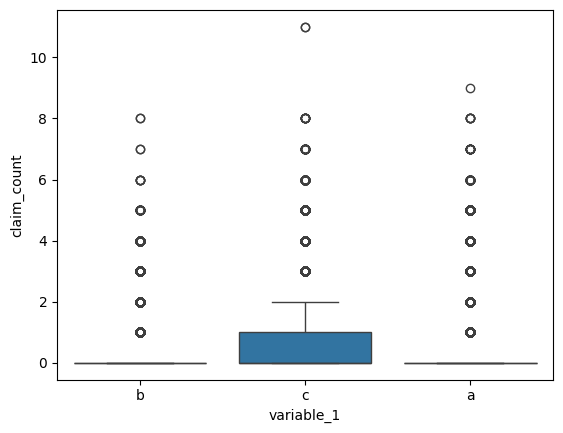

In [6]:
sns.boxplot(x = model_df['variable_1'], y = model_df['claim_count'])
plt.show()

# GLM Model

In [7]:
glm_model = glm('claim_count ~ C(variable_1) + variable_2 + variable_3', 
                    offset = np.log(model_df['exposure']),
                    data = model_df,
                    family = sm.families.Poisson())
glm_result = glm_model.fit()
glm_result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            claim_count   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99995
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -58425.
Date:                Mon, 12 Jan 2026   Deviance:                       62278.
Time:                        20:59:23   Pearson chi2:                 7.43e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4817
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.3416      0.010    137.513      0.000       1.322       1.361
C(variable_1)[T.b]    -0.8430      0.015    -55.710      0.000      -0.873      -0.813
C(variable_1)[T.c]     0.3622      0.011     33.368      0.000       0.341       0.383
variable_2            -0.2645      0.001   -187.903      0.000      -0.267      -0.262
variable_3             0.0001      0.005      0.028      0.978      -0.009       0.010
======================================================================================
"""